<a href="https://colab.research.google.com/github/KennedyPutraKusumo/pydex/blob/master/examples/pydex_quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Setting
Consider a steady-state system with 2 control variables $x_1, x_2$ and 1 response $y$. An order 1 polynomial response surface model is to be developed for the system. You are tasked with designing the experiments for calibrating the model. Use principles of optimal experiment design to design maximally informative experiments. Since the exact number of experiments to be ran is not specified, it is desirable to design an approximate experiment design.

$y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \epsilon$,

where $\epsilon$ is the random error, normally distributed with zero mean and a given standard deviation $\sigma$.

# Step 0: Installing Dependencies

In [16]:
!pip install pydex==0.0.3
!pip install numdifftools
!pip install cvxpy

# Step 1: Import Packages

In [17]:
from pydex.core.designer import Designer
import numpy as np

# Step 2: Specifying the Model
Our system is a steady-state system with two experimental variables, and a single response. The model is specified as a Python function with a specific signature that needs to be followed strictly (order matters). The name of the function does not have to be "simulate" as is presented below. Because we have a steady-state system, our simulate function will have two input arguments, ti_controls, and model_parameters. The input ti_controls will be a 1D numpy array, containing the values of the two experimental variables that pydex will pass into the simulate function. The input model_parameters will also be a 1D numpy array, containing values of the model parameters. The simulate function must return a numpy array, containing a single element, representing the model's predicted response for the given ti_controls, and model_parameters.

In [18]:
def simulate(ti_controls, model_parameters):
    return np.array([
        # constant term
        model_parameters[0] +
        # linear term
        model_parameters[1] * ti_controls[0]                    +
        model_parameters[2] * ti_controls[1]
    ])

Below is an example of what the simulate function is expected to do. The example corresponds to running a simulation to predict the response $y$ when $x_1 = 1$, $x_2 = 2$, $\theta_0 = 1$, $\theta_1 = 2$, and $\theta_2 = 3$.

In [19]:
y = simulate(
    ti_controls=[1, 2],
    model_parameters=[1, 2, 3],
)
print(y)

[9]


# Step 3: Create a Designer, Pass in the Model
To start solving the optimal experimental design problem, we create an instance of pydex's designer. Once instantiated, we will assign the simulate function we have just created to pydex.

In [20]:
designer_1 = Designer()
designer_1.simulate = simulate

To understand what is happening in a bit more detail. All created instances of pydex designers will come with pre-defined attributes and methods. One pre-defined method is the "simulate" method. This is meant to be overwritten. If this pre-defined method is not overwritten, pydex will raise a SyntaxError exception during initialization. This is a feature in pydex to remind you should you forget to specify the simulate function for your model.

# Step 4: Specify Nominal Model Parameter Values
The response surface model for this example is a linear model (with respect to its model parameters). This means that the optimal design for the model is independent of the model parameter values. But, pydex still requires nominal model parameter values to be passed to the designer. You can pick any value, and it will not affect the result. For this example, we choose a value of 1 for all four model parameters. Getting the dimension of the model parameters defined here to be consistent with the dimension required in the simulate function is important.

In [29]:
designer_1.model_parameters = np.ones(4)

The syntax is again similar with specifying the simulate function. When instantiated, a designer will come with a pre-defined attribute named "model_parameters" that needs to be overwritten. We overwrite this with a 1D numpy array with all elements equal to one.

# Step 5: Specify Experimental Candidates
This step is specific to how pydex solves optimal experiment design problems. Before proceeding, it is important to note that it is customary in optimal experiment design to normalize the experimental controls so they take values between -1 and 1.

For this example, since we have two experimental controls, we will need to generate a 2D numpy array with shapes $N_c \times 2$; where $N_c$ is the total number of experimental candidates. For simplicity, we will pass in candidates from a 2D mesh-centered grid with 5 levels in each dimension. This leads to a total of $5^2$ number of experimental candidates. To generate the required 2D numpy array, we will use pydex's convenient shortcut method: "enumerate_candidates".



In [22]:
tic = designer_1.enumerate_candidates(
    bounds=[
            [-1, 1],
            [-1, 1],
    ],
    levels=[
            5, 
            5,
    ],
)  # tic stands for time-invariant control

The syntax to the shortcut method requires us to pass in the bounds of the two-dimensional grid we are going to enumerate our candidates from. This bounds will be declared either as a 2d numpy array, or as shown above, as a list of 2-element lists. Additionally, we need to specify the number of levels for each dimension, passed in as a 1d numpy array or a list. The shortcut produces a 2D numpy array of size $25 \times 2$.

In [23]:
print(np.array2string(tic, separator=", "))

[[-1. , -1. ],
 [-1. , -0.5],
 [-1. ,  0. ],
 [-1. ,  0.5],
 [-1. ,  1. ],
 [-0.5, -1. ],
 [-0.5, -0.5],
 [-0.5,  0. ],
 [-0.5,  0.5],
 [-0.5,  1. ],
 [ 0. , -1. ],
 [ 0. , -0.5],
 [ 0. ,  0. ],
 [ 0. ,  0.5],
 [ 0. ,  1. ],
 [ 0.5, -1. ],
 [ 0.5, -0.5],
 [ 0.5,  0. ],
 [ 0.5,  0.5],
 [ 0.5,  1. ],
 [ 1. , -1. ],
 [ 1. , -0.5],
 [ 1. ,  0. ],
 [ 1. ,  0.5],
 [ 1. ,  1. ]]


After generating the required tic array, we need to pass it on to pydex. Now, we overwrite the pre-defined attribute ti_controls_candidates.

In [24]:
designer_1.ti_controls_candidates = tic

# Step 6: Initialize the Designer
We have specified the model through the simulate function, and specified the experimental candidates through the overwriting the ti_controls_candidates attributes. We are ready to solve our experimental design problem.

Before the designer can be used to conduct any activity, it needs to be initialized. During initialization, the designer is going to do two things. First, check if there are any syntax errors made so far. Second, run a single simulation (using the first experimental candidate) to determine the number of responses (as defined in the simulate function).

During initialization, you will also have a choice to determine how verbal you want the designer to be as it conducts experiment design, or any other activity. This is done by setting the verbose value. Note: although you can assign any real values, verbose is recommended to be a positive integer. 0: silent, 1: overview, 2: detailed, 3: very detailed.

In [25]:
designer_1.initialize(verbose=2)

Initialization complete: designer ready.
----------------------------------------------------------------------------------------------------
Number of model parameters              : 4
Number of candidates                    : 25
Number of responses                     : 1
Number of measured responses            : 1
Number of time-invariant controls       : 2


'ready'

After initialization, pydex reports the generic problem statistics that we have passed in. This helps us check if everything was defined properly.

# Step 7: Design the Optimal Experiment
To design an experiment, we invoke the pre-defined method design_experiment. There is one required argument: criterion. Pydex comes with multiple pre-defined list of experimental design criteria. We will use a popular classical optimality criterion, the D-optimal criterion.

In addition to the criterion, we pass in three optional arguments. In this demo, we will not have authorization to write new files. By default, pydex will attempt to write the log of the experimental design activity into a text file. To prevent an error to occur, we pass in the argument "write=False". An important component of solving the optimal experimental design problem is the numerical optimizer that pydex will use. Pydex currently interfaces with solvers via two packages: Python's scipy and cvxpy. Pydex defaults to Python's cvxpy package, and "SCS" optimizer. We pass in 'package="scipy"' and 'optimizer="SLSQP"' to use the SLSQP optimizer, available through Python's scipy library.

In [26]:
result = designer_1.design_experiment(
    criterion=designer_1.d_opt_criterion,
    write=False,
    package="scipy",
    optimizer="SLSQP",
)

############################### Computing Optimal Experiment Design ################################
Started on                              : 2020-09-09 13:24:56.380428
Criterion                               : d_opt_criterion
Pseudo-bayesian                         : False
Dynamic                                 : False
Time-invariant Controls                 : True
Time-varying Controls                   : False
Number of Candidates                    : 25
---------------------------------------[Sensitivity Analysis]---------------------------------------
[Candidate       3/25]: time elapsed            0.01 seconds.
[Candidate       6/25]: time elapsed            0.02 seconds.
[Candidate       9/25]: time elapsed            0.03 seconds.
[Candidate      12/25]: time elapsed            0.04 seconds.
[Candidate      15/25]: time elapsed            0.05 seconds.
[Candidate      18/25]: time elapsed            0.06 seconds.
[Candidate      21/25]: time elapsed            0.07 seconds.
[

Because we specified a verbosity of 2, the designer provides details of the activity, numerical optimizer, and the overall timings. As was reported, there are two main steps to solving the optimal experimental design problem. The first is the sensitivity analysis step. Pydex does this through numerical estimation using finite differences, coupled with Richardson extrapolation to increase accuracy. This took 0.09 seconds to complete. The second step is to solve an optimization problem, which the optimizer SLSQP took 0.05 CPU seconds to complete.

# Step 8: Visualize the Results
Once we complete an experimental design problem, we need to visualize the results. Pydex comes with many built-in visualization methods. The main method to invoke is "print_optimal_candidates". By default pydex will try to save the printed optimal candidates into a text file. But, we do not have authorization, to prevent an error, we pass in the "write=False" argument.


In [27]:
designer_1.print_optimal_candidates(write=False)


######################################## Optimal Candidates ########################################
Obtained on                             : 2020-09-09 13:24:56.527295
Criterion                               : d_opt_criterion
Pseudo-bayesian                         : False
Dynamic                                 : False
Time-invariant Controls                 : True
Time-varying Controls                   : False
Number of Candidates                    : 25
Number of Optimal Candidates            : 4
-------------------------------------------[Candidate 1]--------------------------------------------
                             Recommended Effort: 25.00% of experiments                              
Time-invariant Controls:
[-1. -1.]
-------------------------------------------[Candidate 5]--------------------------------------------
                             Recommended Effort: 25.00% of experiments                              
Time-invariant Controls:
[-1.  1.]
-----------------

The method prints various details about the experimental design activity that was solved to obtained the optimal candidates. This is useful for identifying the results. We see that there are four optimal candidates selected out of our original 25 experimental candidates. The D-optimal criterion recommends that we put equal experimental efforts to these four optimal candidates. The optimal candidates are given numbers for identification. Additionally, the time-invariant controls associated with the candidates are also printed. In cases where we have dynamic systems with both time-invariant and time-varying controls, both of these, along with the sampling times will be printed here.

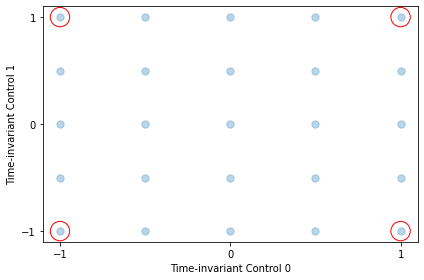

In [28]:
designer_1.plot_optimal_controls(non_opt_candidates=True)
designer_1.show_plots()

For dynamic systems with up to four experimental variables, pydex offers a useful visualization method: "plot_optimal_controls". The method generates a scatter plot of the computed experimental design. By default, pydex will not scatter all of the enumerated experimental candidates as it may take a long time, and/or result in a messy figure. But, we pass in "non_opt_candidates=True" for our demo. This scatter plots the experimental variables, which showcases the symmetrical structure of the computed experimental design. The radius of the hollow red circles represent the computed optimal efforts associated with each experimental candidate. The larger the effort, the larger the radius. An effort of zero will cause the hollow circles to disappear.